In [51]:
import logging

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np

# no idea why this is still necessary
np.float_ = np.float64

from prophet import Prophet
from prophet.utilities import regressor_coefficients

from get_model_training_data_05 import get_features_and_data_monthly
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

logger = logging.getLogger("cmdstanpy")
logger.setLevel(logging.ERROR)

## Load Training and Testing Data

In [52]:
(df, train_df, test_df, features, next_month) = get_features_and_data_monthly()

training examples = 86, testing examples = 10


In [53]:
target = "n_releases"

In [54]:
df["ds"] = df["month_year"].dt.to_timestamp(how="end")
train_df["ds"] = train_df["month_year"].dt.to_timestamp(how="end")
test_df["ds"] = test_df["month_year"].dt.to_timestamp(how="end")
next_month["ds"] = next_month["month_year"].dt.to_timestamp(how="end")

In [55]:
df = df.rename(columns={target : "y"})
train_df = train_df.rename(columns={target : "y"})
test_df = test_df.rename(columns={target : "y"})
next_month = next_month.rename(columns={target : "y"})

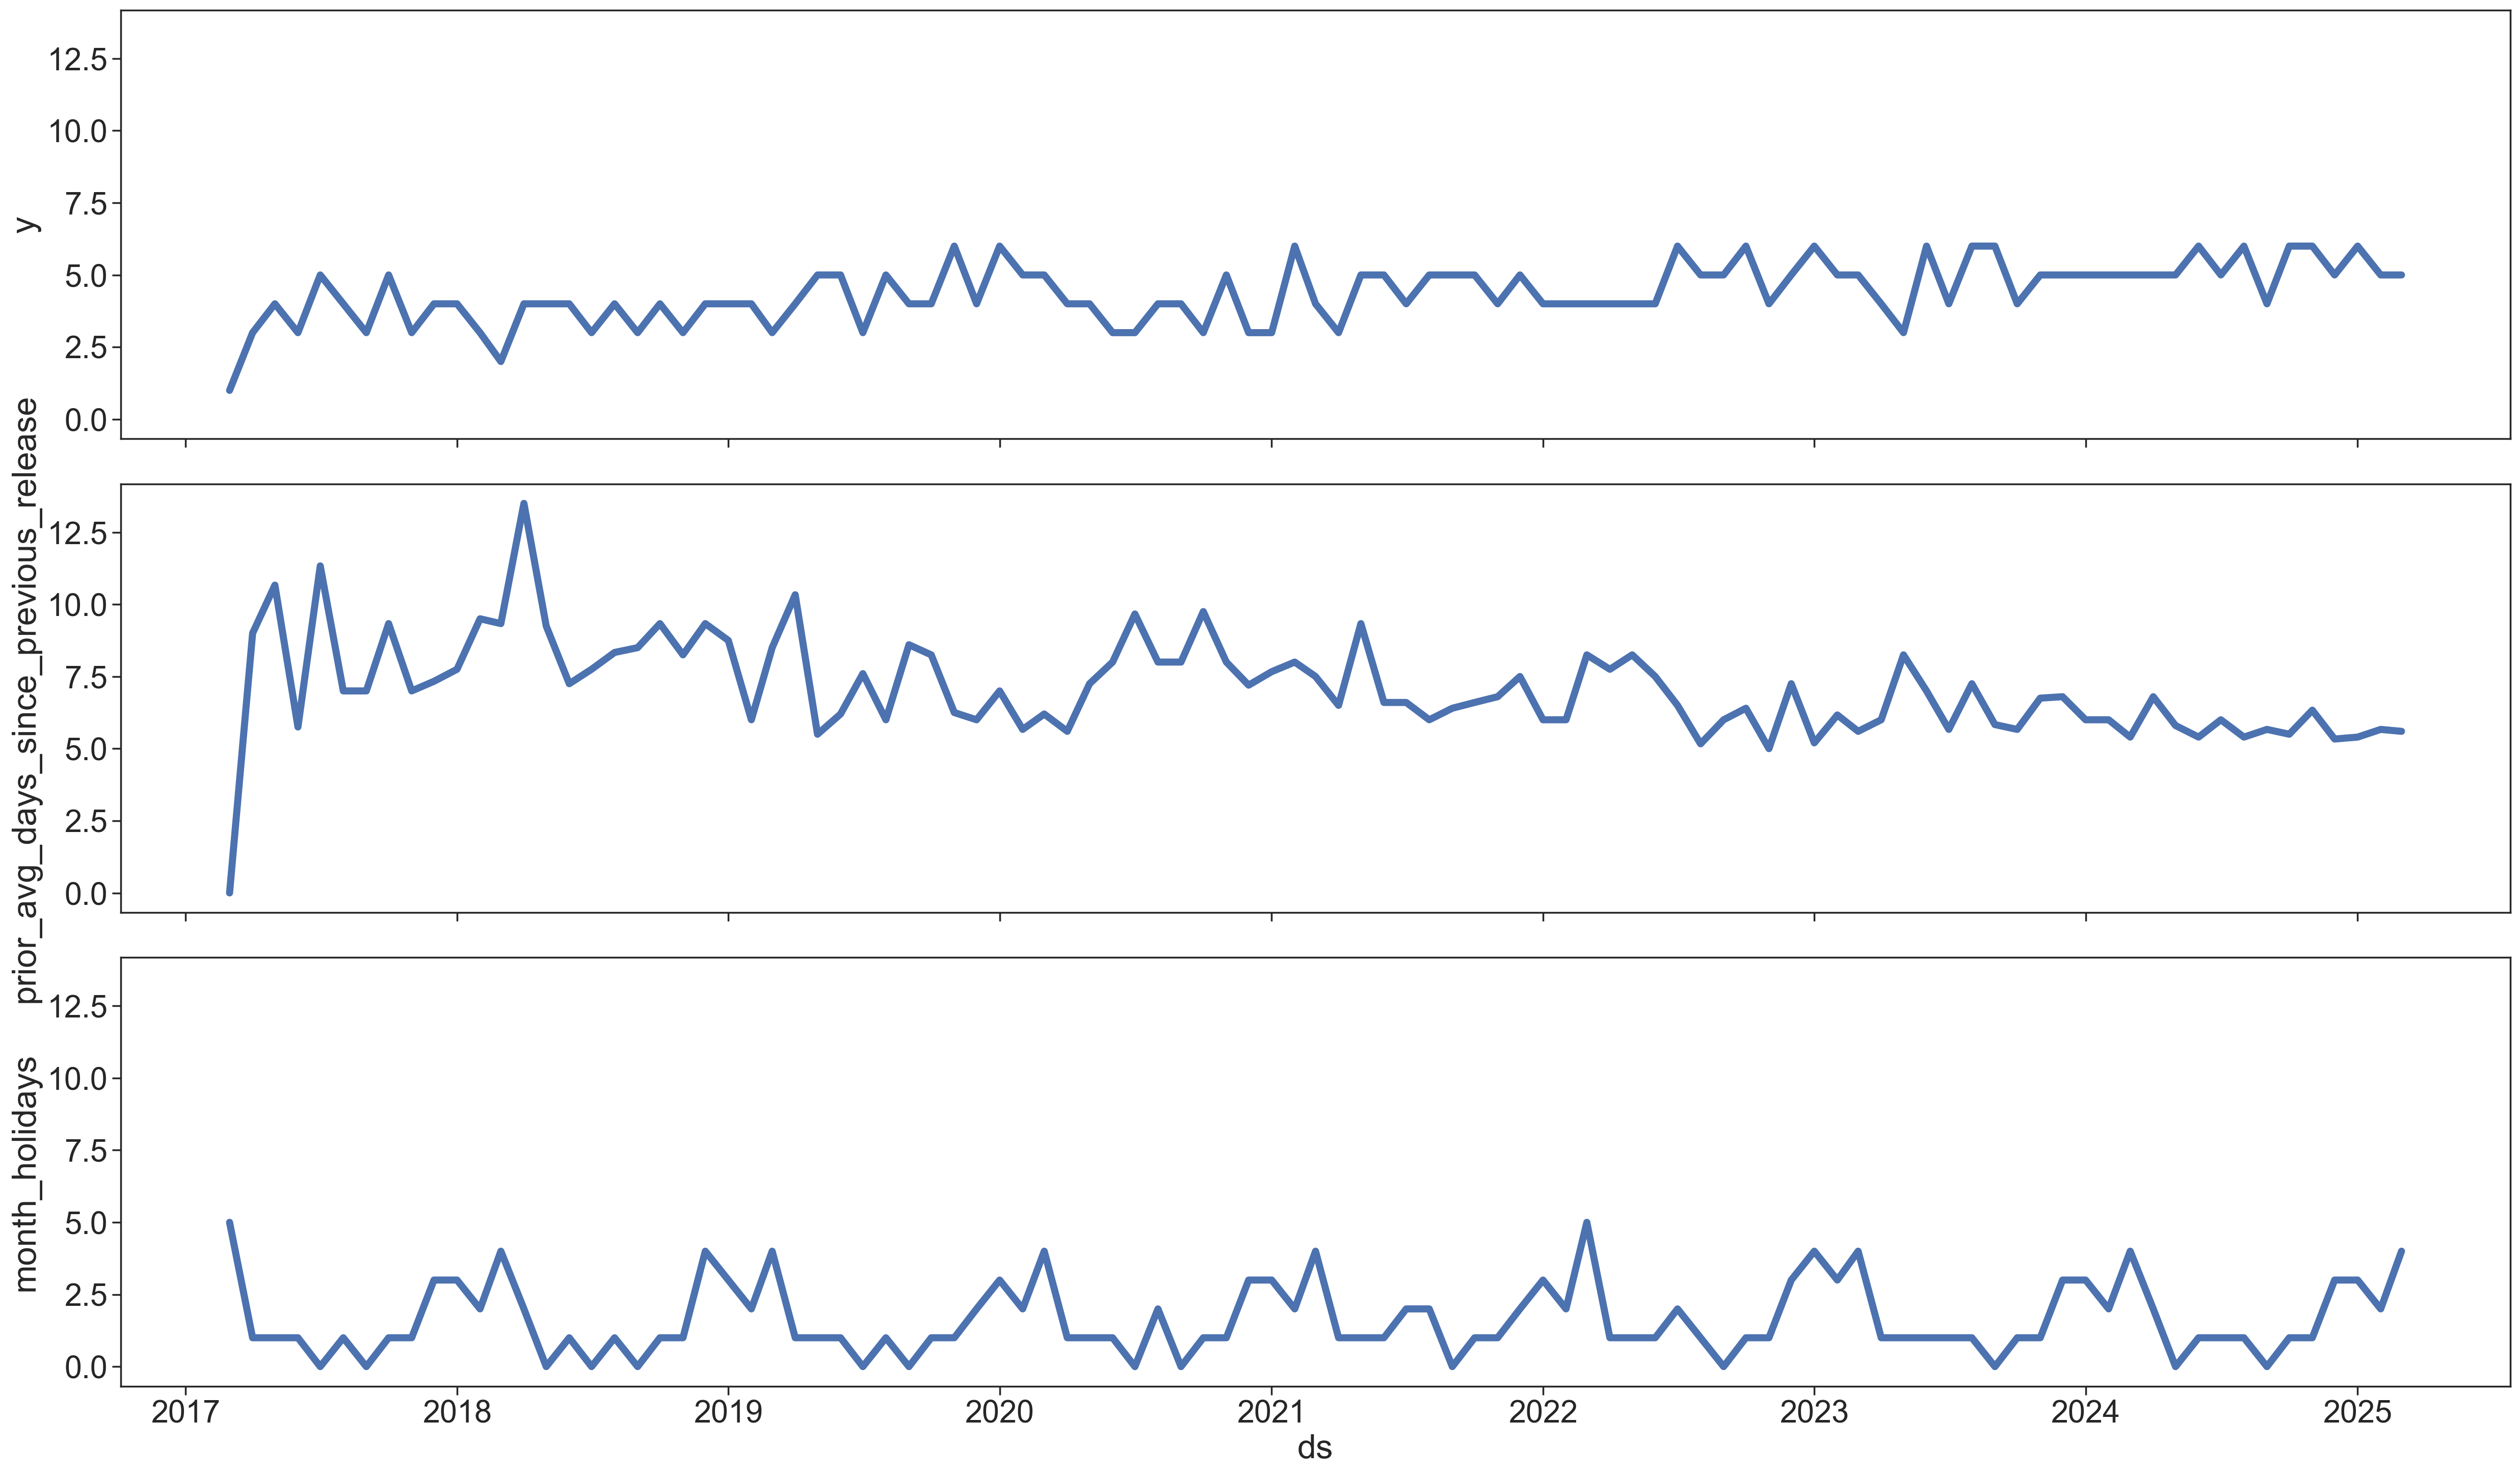

In [57]:
(fig, axs) = plt.subplots(3, 1, sharex=True, sharey=True)

sns.lineplot(data=df, x="ds", y="y", linewidth=5, ax=axs[0])
sns.lineplot(data=df, x="ds", y=features[0], linewidth=5, ax=axs[1])
sns.lineplot(data=df, x="ds", y=features[1], linewidth=5, ax=axs[2])

plt.tight_layout()

In [58]:
df[features + ["y"]].corr()

,prior_avg_days_since_previous_release,month_holidays,y
prior_avg_days_since_previous_release,1.000000,-0.199641,-0.224892
month_holidays,-0.199641,1.000000,-0.031859
y,-0.224892,-0.031859,1.000000


## Model-Building and Evaluation

In [59]:
def train_model(this_train_df, features=features, target=target):
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, #growth="flat",
                mcmc_samples=500, interval_width=0.95)#, seasonality_prior_scale=15, seasonality_mode="multiplicative")
    # m.add_country_holidays("US")
    for col in features:
        m.add_regressor(col)

    m.fit(this_train_df, seed=1024)
    # print(m.stan_fit.diagnose())

    return m

In [60]:
model = train_model(train_df)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [61]:
test_hat_df = model.predict(test_df)[["ds", "yhat_lower", "yhat", "yhat_upper"]].round(0)
test_hat_df = test_hat_df.merge(test_df[["ds", "y"]], on=["ds"], how="left")
test_hat_df

,ds,yhat_lower,yhat,yhat_upper,y
0,2024-04-30 23:59:59.999999999,3.0,5.0,7.0,5
1,2024-05-31 23:59:59.999999999,2.0,4.0,7.0,6
2,2024-06-30 23:59:59.999999999,3.0,5.0,7.0,5
3,2024-07-31 23:59:59.999999999,3.0,5.0,7.0,6
4,2024-08-31 23:59:59.999999999,3.0,5.0,8.0,4
5,2024-09-30 23:59:59.999999999,4.0,6.0,8.0,6
6,2024-10-31 23:59:59.999999999,3.0,5.0,8.0,6
7,2024-11-30 23:59:59.999999999,3.0,5.0,8.0,5
8,2024-12-31 23:59:59.999999999,2.0,5.0,7.0,6
9,2025-01-31 23:59:59.999999999,4.0,6.0,8.0,5


In [62]:
mape(test_hat_df["y"], test_hat_df["yhat"])

0.12833333333333333

In [63]:
wape(test_hat_df["y"], test_hat_df["yhat"])

np.float64(0.12962962962962962)

In [64]:
regressor_coef = regressor_coefficients(model)
regressor_coef.sort_values(by=["coef"], ascending=False)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
1,month_holidays,additive,1.651163,-0.394854,0.104987,0.604902
0,prior_avg_days_since_previous_release,additive,7.287984,-0.096414,0.041790,0.188989


## Predictions for the Next Month

In [65]:
model = train_model(df)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [66]:
next_month_hat = model.predict(next_month)[["ds", "yhat_lower", "yhat", "yhat_upper"]].round(0)
next_month_hat = next_month_hat.merge(next_month[["ds", "y"]], on=["ds"], how="left")
next_month_hat

,ds,yhat_lower,yhat,yhat_upper,y
0,2025-02-28 23:59:59.999999999,3.0,5.0,7.0,5
